In [110]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import resample, shuffle
import seaborn as sb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
dir = 'archive'

In [6]:
#getting the subdirectories from the root directory 'archive' 
female_eyes_dir = os.path.join(dir, 'femaleeyes')
male_eyes_dir = os.path.join(dir, 'maleeyes')

In [8]:
#Obtaining the number of images present in each directory
female_eyes_count = len(os.listdir(female_eyes_dir))
male_eyes_count = len(os.listdir(male_eyes_dir))

print('Count of female eyes in the directory: ', female_eyes_count)
print('Count of male eyes in the directory: ',male_eyes_count)

Count of female eyes in the directory:  5202
Count of male eyes in the directory:  6323


In [12]:
#creating a pandas dataframe with image path and label by unpacking the root directory using os.walk()
label = []
path = []
for root, dirs, files in os.walk(dir):
    for file in files:
        label.append(os.path.split(root)[1])
        path.append(os.path.join(root, file))
image_df = pd.DataFrame({'Image': path, 'Label': label})

In [14]:
image_df.head()

,Image,Label
0,archive\femaleeyes\1.jpg,femaleeyes
1,archive\femaleeyes\10.jpg,femaleeyes
2,archive\femaleeyes\100.jpg,femaleeyes
3,archive\femaleeyes\1000.jpg,femaleeyes
4,archive\femaleeyes\1001.jpg,femaleeyes


### Shuffling the dataset so that the male eyes and female eyes are spread over entirely

In [16]:
image_df = image_df.sample(frac=1)

In [18]:
image_df.head()

,Image,Label
9577,archive\maleeyes\5667.jpg,maleeyes
7702,archive\maleeyes\3673.jpg,maleeyes
5195,archive\femaleeyes\989.jpg,femaleeyes
10756,archive\maleeyes\6903.jpg,maleeyes
5671,archive\maleeyes\1491.jpg,maleeyes


In [20]:
image_df.describe()

,Image,Label
count,11525,11525
unique,11525,2
top,archive\maleeyes\5667.jpg,maleeyes
freq,1,6323


In [22]:
image_df.isna().sum()

Image    0
Label    0
dtype: int64

#### Observation: There are no missing values in the dataset

In [24]:
gender_eye_counts = image_df['Label'].value_counts()
print(gender_eye_counts)

Label
maleeyes      6323
femaleeyes    5202
Name: count, dtype: int64


#### Observation: The number of male eyes is greater than number of female eyes

### Downsampling the male eyes data to balance the dataset

In [26]:
img_df_major = image_df[image_df['Label'] == 'maleeyes']
img_df_minor = image_df[image_df['Label'] == 'femaleeyes']

img_df_major_resampled = resample(img_df_major, replace=False, n_samples=5202, random_state=42)
image_df = pd.concat([img_df_major_resampled, img_df_minor])
image_df = shuffle(image_df)
image_df = image_df.reset_index(drop=True)
print(image_df['Label'].value_counts())
image_df.describe()

Label
femaleeyes    5202
maleeyes      5202
Name: count, dtype: int64


,Image,Label
count,10404,10404
unique,10404,2
top,archive\femaleeyes\3381.jpg,femaleeyes
freq,1,5202


In [28]:
#get the first image from both maleeyes and femaleeyes directory
female_img = image_df[image_df['Label'] == 'femaleeyes'].index[0]
male_img = image_df[image_df['Label'] == 'maleeyes'].index[0]

### Plot a graph for a female eye to find the dimensions

Text(0.5, 1.0, 'femaleeyes')

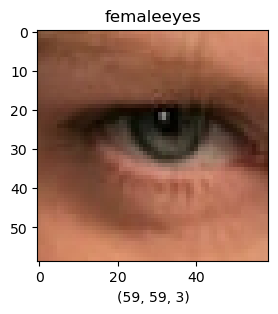

In [30]:
fig = plt.figure(figsize=(3,3))
x = plt.imread(image_df['Image'][female_img])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(image_df['Label'][female_img])

### Plot a graph for a male eye to find the dimensions

Text(0.5, 1.0, 'maleeyes')

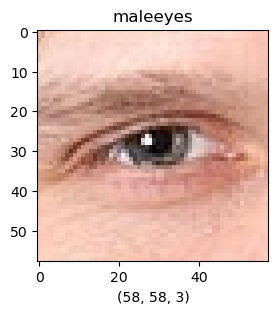

In [32]:
fig = plt.figure(figsize=(3,3))
x = plt.imread(image_df['Image'][male_img])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(image_df['Label'][male_img])


### Observation: Here we can notice that the shape of female eye image and male eye image are different. Let us find the smallest and largest shape of the images for a better idea.

In [34]:
#creation of a set to record different sizes(unique) of images in the dataset.
img_sizes = set()
for img in range(len(image_df['Image'])):
    img_sizes.add(plt.imread(image_df['Image'][img]).shape)

print(len(img_sizes))
print('Smallest size in the set: ', list(sorted(img_sizes))[0])
print('Largest size in the set: ', list(sorted(img_sizes))[-1])

65
Smallest size in the set:  (41, 41, 3)
Largest size in the set:  (113, 113, 3)


### Observation: The dataset contains 65 different image sizes, ranging from 41x41 to 117x117. All the images will now be resized to same shape for better classification.

### Resizing the images to (64,64):

In [38]:
size = (64, 64)
image_df_cp = image_df.copy()
img_sizes = set()
for i in range(len(image_df)):
    img = cv2.imread(image_df['Image'][i])
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_sizes.add(img.shape)
    #flattening the image to feed it to the model and save memory.
    image_df_cp['Image'][i] = img.flatten()

In [40]:
img_sizes

{(64, 64, 3)}

### Observation: We can now see that the entire set has only one size 79x79 which means all the images in the dataset were resized to 79x79. 

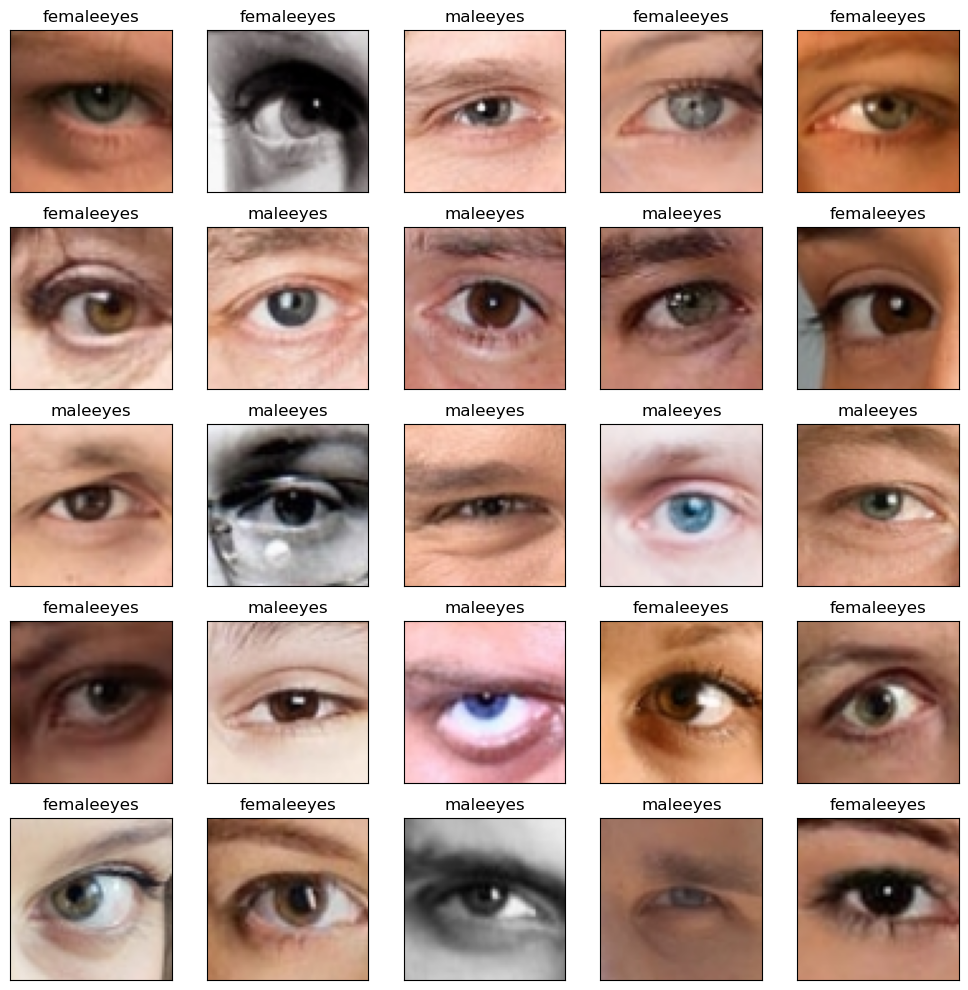

In [42]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, a in enumerate(ax.flat):
    a.imshow(image_df_cp['Image'][i].reshape(64,64,3))
    a.set_title(image_df_cp['Label'][i])
plt.tight_layout()
plt.show()

In [44]:
#encoding the label(target variable)
le = LabelEncoder()
image_df_cp['Label'] = np.asarray(le.fit_transform(image_df_cp['Label']))

In [46]:
image_df_cp.head()

,Image,Label
0,"[124, 84, 59, 130, 90, 65, 137, 93, 68, 138, 9...",0
1,"[115, 109, 109, 107, 101, 101, 100, 94, 94, 99...",0
2,"[225, 181, 156, 210, 168, 144, 238, 197, 176, ...",1
3,"[244, 184, 160, 244, 184, 160, 243, 184, 159, ...",0
4,"[232, 138, 86, 232, 138, 86, 231, 137, 86, 230...",0


### KNN

In [48]:
#stacking all the image arrays into one
def clean(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [52]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(image_df_cp['Image'], image_df_cp['Label'], test_size=0.2, random_state=42)
X_train1, X_test1, Y_train1, Y_test1 = clean([X_train1, X_test1, Y_train1, Y_test1])
print('Shape of X_train1: ', X_train1.shape)
print('Shape of X_test1: ', X_test1.shape)
print('Shape of Y_train1: ', Y_train1.shape)
print('Shape of Y_test1: ', Y_test1.shape)

Shape of X_train1:  (8323, 12288)
Shape of X_test1:  (2081, 12288)
Shape of Y_train1:  (8323, 1)
Shape of Y_test1:  (2081, 1)


In [54]:
err_rate = []
for i in range(1, 5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train1, Y_train1)
    pred_i = knn.predict(X_test1)
    err_rate.append(np.mean(pred_i != Y_test1))

Text(0, 0.5, 'Error Rate')

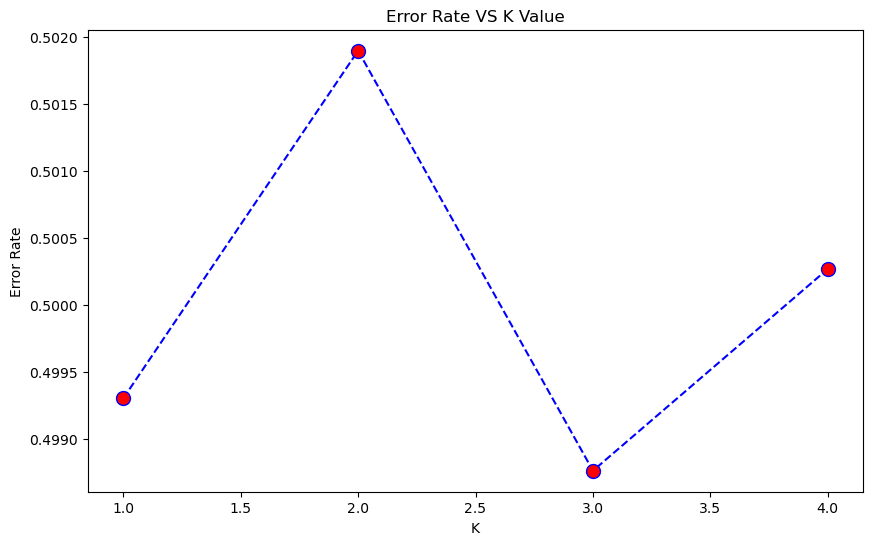

In [56]:
plt.figure(figsize=(10,6))
plt.plot(range(1,5),err_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate VS K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [58]:
KNN = KNeighborsClassifier(n_neighbors=20)
KNN.fit(X_train1, Y_train1)
knn_pred = KNN.predict(X_test1)

In [60]:
print('KNN Accuracy: ', accuracy_score(Y_test1, knn_pred))

KNN Accuracy:  0.8255646323882748


### Observation: The accuracy of the KNN model is 82.55%

Text(0.5, 1.0, 'Accuracy Score: 0.8255646323882748')

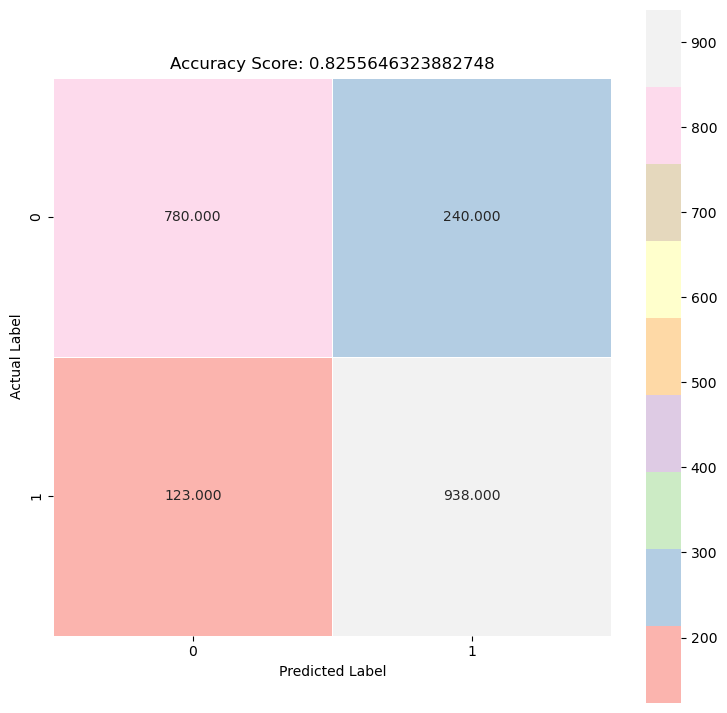

In [62]:
knn_cm = confusion_matrix(Y_test1, knn_pred)
plt.figure(figsize=(9, 9))
sb.heatmap(knn_cm, annot=True, fmt='.3f', linewidths=0.5, square=True, cmap='Pastel1')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy Score: {0}'.format(accuracy_score(Y_test1, knn_pred)))

### Confusion matrix values:
<li> True Positives: 780 </li>
<li> False Positives: 240 </li>
<li> False Negatives: 123 </li>
<li> True Negatives: 938 </li>

In [64]:
knn_classification_report = classification_report(Y_test1, knn_pred)
print(knn_classification_report)

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1020
           1       0.80      0.88      0.84      1061

    accuracy                           0.83      2081
   macro avg       0.83      0.82      0.82      2081
weighted avg       0.83      0.83      0.82      2081



### Observation:
<li> For class 0, the precision is 0.86. This means that 86% of the instances predicted as class 0 are actually class 0. </li>
<li> For class 1, the precision is 0.80. This means that 80% of the instances predicted as class 1 are actually class 1. </li>
<li> For class 0, the recall is 0.76. This indicates that the model correctly identified 76% of the actual class 0 instances. </li>
<li> For class 1, the recall is 0.88. This indicates that the model correctly identified 88% of the actual class 1 instances. </li>
<li> For class 0, the F1-score is 0.81. For class 1, the F1-score is 0.84. </li>


### MLP

In [66]:
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(image_df_cp['Image'], image_df_cp['Label'], test_size=0.4, random_state=42)
X_val2, X_test2, Y_val2, Y_test2 = train_test_split(X_val2, Y_val2, test_size=0.5, random_state=42)
X_train2, X_val2, X_test2, Y_train2, Y_val2, Y_test2 = clean([X_train2, X_val2, X_test2, Y_train2, Y_val2, Y_test2])

print("X_train shape: ", X_train2.shape) 
print("X_val shape: ", X_val2.shape) 
print("X_test shape: ", X_test2.shape) 
print("Y_train shape: ", Y_train2.shape) 
print("Y_val shape: ", Y_val2.shape) 
print("Y_test shape: ", Y_test2.shape) 

X_train shape:  (6242, 12288)
X_val shape:  (2081, 12288)
X_test shape:  (2081, 12288)
Y_train shape:  (6242, 1)
Y_val shape:  (2081, 1)
Y_test shape:  (2081, 1)


### Network Architecture

### Early Stopping is used to prevent overfitting by stopping the training if the model performance is same over a few set of iterations. Using patience parameter, the loss is monitored for 5 iterations and if loss doesn't improve, the training is stopped.

In [68]:
es = EarlyStopping(monitor='loss', patience=5)

In [70]:
X_train2[0]

array([ 96,  29,  23, ..., 241, 214, 187], dtype=uint8)

### Intuition behind the architecture:
<li> 1024 neurons in the first layer has been used to handle high-dimensional data (like images). </li>
<li> Activation: leaky_relu has been used to address the dying ReLU problem, where neurons can become inactive and stop learning entirely if the inputs always produce a zero gradient.</li>
<li> 512 neurons in the second layer has been used to show a funneling effect, where the network is progressively learning more abstract and higher-level features. </li>
<li> Activation: relu has been used to introduce non-linearity to the model which allows it to learn more complex functions. </li>
<li> Dropout helps in reducing overfitting by randomly deactivating 50% of neurons during training. </li>
<li> 1 neuron has been used to capture the output in the last layer. </li>
<li> Activation: sigmoid maps the output to a value between 0 and 1, which can be interpreted as a probability. This is particularly useful for binary classification tasks (our problem), as it enables the model to output a probability score indicating the likelihood of the input belonging to the positive class.</li>

In [72]:
MLP = Sequential([Dense(1024, activation='leaky_relu'),
                  Dropout(0.5),
                  Dense(512, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation='sigmoid')
                 ])

In [74]:
#mapping the class weights for male and female eyes
male_entries = len(Y_train2[Y_train2 > 0])
female_entries = len(Y_train2) - male_entries
total_entries = len(Y_train2)
weight_male = total_entries / (2*male_entries)
weight_female = total_entries / (2*female_entries)
class_weights = {0: weight_female, 1: weight_male}
print(class_weights)

adam_optimizer = Adam()

{0: 0.9945825366475463, 1: 1.0054768041237114}


In [76]:
#Since it is a binary classification problem, binary_crossentropy has been used as a loss function.
MLP.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'), 
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
    ]
)

### Training

In [80]:
#Scaling has been used so that all the features are considered equally and provide a better and fair classification.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
mlp_history = MLP.fit(X_train_scaled, Y_train2, class_weight=class_weights, batch_size=64, validation_data=(X_val2, Y_val2), callbacks=[es], epochs=20)

Epoch 1/20
98/98 [==============================] - 22s 196ms/step - loss: 6.1271 - tp: 2195.0000 - fp: 968.0000 - tn: 2170.0000 - fn: 909.0000 - accuracy: 0.6993 - precision: 0.6940 - recall: 0.7072 - auc: 0.7248 - val_loss: 674.8798 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 1057.0000 - val_fn: 1018.0000 - val_accuracy: 0.5108 - val_precision: 1.0000 - val_recall: 0.0059 - val_auc: 0.5029
Epoch 2/20
98/98 [==============================] - 18s 185ms/step - loss: 2.0895 - tp: 2446.0000 - fp: 718.0000 - tn: 2420.0000 - fn: 658.0000 - accuracy: 0.7796 - precision: 0.7731 - recall: 0.7880 - auc: 0.8214 - val_loss: 65.6853 - val_tp: 319.0000 - val_fp: 43.0000 - val_tn: 1014.0000 - val_fn: 705.0000 - val_accuracy: 0.6406 - val_precision: 0.8812 - val_recall: 0.3115 - val_auc: 0.6390
Epoch 3/20
98/98 [==============================] - 20s 202ms/step - loss: 0.8316 - tp: 2430.0000 - fp: 675.0000 - tn: 2463.0000 - fn: 674.0000 - accuracy: 0.7839 - precision: 0.7826 - recall: 0.7829 - auc

In [82]:
X_test_scaled = scaler.fit_transform(X_test2)
metrics = MLP.evaluate(X_test_scaled, Y_test2, verbose=0)
print('Test loss: ', metrics[0])
print('Test Accuracy: ', metrics[1])


Test loss:  0.26820069551467896
Test Accuracy:  971.0


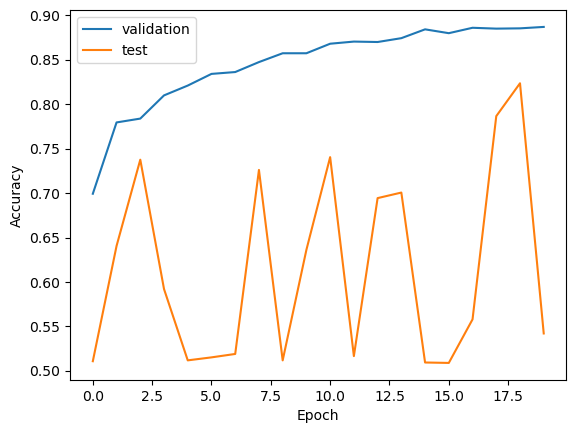

In [84]:
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['validation', 'test'], loc='upper left')
plt.show()

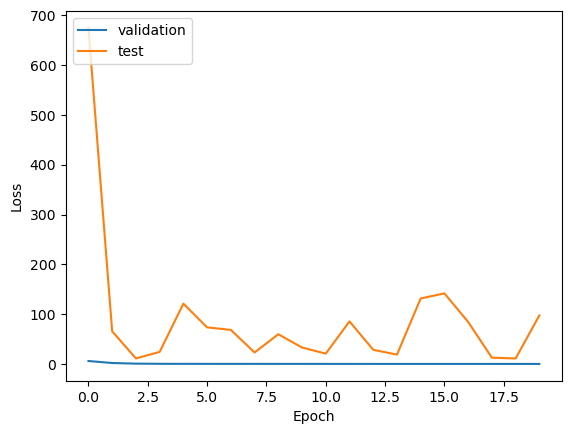

In [86]:
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['validation', 'test'], loc='upper left')
plt.show()

In [88]:
Y_pred2 = MLP.predict(X_test_scaled)
Y_pred2

66/66 [==============================] - 2s 30ms/step


array([[9.9763578e-01],
       [3.6974985e-02],
       [9.8570043e-01],
       ...,
       [7.5378949e-08],
       [1.4506538e-01],
       [1.0000000e+00]], dtype=float32)

In [92]:
Y_pred2 = np.where(Y_pred2 > 0.5, 1, 0)
Y_pred2

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [94]:
MLP_classification_report = classification_report(Y_test2, Y_pred2)
print(MLP_classification_report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1007
           1       0.90      0.90      0.90      1074

    accuracy                           0.90      2081
   macro avg       0.90      0.90      0.90      2081
weighted avg       0.90      0.90      0.90      2081



### Observation:
<li> For class 0, the precision is 0.90. This means that 90% of the instances predicted as class 0 are actually class 0. </li>
<li> For class 1, the precision is 0.90. This means that 90% of the instances predicted as class 1 are actually class 1. </li>
<li> For class 0, the recall is 0.90. This indicates that the model correctly identified 90% of the actual class 0 instances. </li>
<li> For class 1, the recall is 0.90. This indicates that the model correctly identified 90% of the actual class 1 instances. </li>
<li> For class 0, the F1-score is 0.90. For class 1, the F1-score is 0.90. </li>


### CNN

In [96]:
#converting the image array into tensor
def to_tensor(t):
    l = []
    for i in range(len(t)):
        l.append(tf.convert_to_tensor(t[i]))
    return l

#stacking all the image arrays into one
def clean(X):
    for i in range(len(X)):
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X
        

In [98]:
size = (64,64)
img_df_cp = image_df.copy()

for i in range(len(image_df)):
    image=cv2.imread(image_df['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_df_cp['Image'][i] = image
    
# Convert labels(target variable) to numeric values
le = LabelEncoder()
img_df_cp['Label'] = np.asarray(le.fit_transform(img_df_cp["Label"]))

In [100]:
img_df_cp.head()

,Image,Label
0,"[[[124, 84, 59], [130, 90, 65], [137, 93, 68],...",0
1,"[[[115, 109, 109], [107, 101, 101], [100, 94, ...",0
2,"[[[225, 181, 156], [210, 168, 144], [238, 197,...",1
3,"[[[244, 184, 160], [244, 184, 160], [243, 184,...",0
4,"[[[232, 138, 86], [232, 138, 86], [231, 137, 8...",0


In [108]:
X_train3, X_val3, Y_train3, Y_val3 = train_test_split(img_df_cp['Image'], img_df_cp['Label'], test_size=0.4, random_state=42)
X_val3, X_test3, Y_val3, Y_test3 = train_test_split(X_val3, Y_val3, test_size=0.5, random_state=42)
X_train3, X_val3, X_test3, Y_train3, Y_val3, Y_test3 = clean([X_train3, X_val3, X_test3, Y_train3, Y_val3, Y_test3])
X_train3, X_val3, X_test3, Y_train3, Y_val3, Y_test3 = to_tensor([X_train3, X_val3, X_test3, Y_train3, Y_val3, Y_test3])

print("X_train shape: ", X_train3.shape) 
print("X_val shape: ", X_val3.shape) 
print("X_test shape: ", X_test3.shape) 
print("Y_train shape: ", Y_train3.shape) 
print("Y_val shape: ", Y_val3.shape) 
print("Y_test shape: ", Y_test3.shape) 

X_train shape:  (6242, 64, 64, 3)
X_val shape:  (2081, 64, 64, 3)
X_test shape:  (2081, 64, 64, 3)
Y_train shape:  (6242,)
Y_val shape:  (2081,)
Y_test shape:  (2081,)


### Model Architecture

### Intuition behind the model architecture
<li> The first convolutional layer has 128 filters, a large kernel size of 11x11, and a stride of 4. This layer is responsible for detecting low-level features such as edges and textures from the input images (64x64 with 3 color channels). </li>
<li> The ReLU activation function introduces non-linearity, allowing the network to learn more complex features.</li>
<li> BatchNormalization() normalizes the output of the previous convolutional layer, stabilizing and speeding up the training process by reducing internal covariate shift.</li>
<li> MaxPooling2d() reduces the spatial dimensions (height and width) of the feature maps, retaining the most important features while reducing computational complexity and preventing overfitting. A pool size of 2x2 means it takes the maximum value from each 2x2 block of the feature map.</li>
<li> The second convolutional layer has 256 filters, a kernel size of 5x5, and 'same' padding to preserve the spatial dimensions of the input. It captures more complex features.</li>
<li> BatchNormalization() is again used to normalize the output of the previous layer.</li>
<li> MaxPooling2D() with a pool size of 3x3 further reduces the dimension of the feature maps.</li>
<li> The next convolutional layer has 256 filters and a kernel size of 3x3, maintaining the spatial dimensions with 'same' padding.</li>
<li> BatchNormalization() normalizes the output of the previous layer.</li>
<li> Using 2 1x1 convolutional layers and applying BatchNormalization()</li>
<li> The next 1x1 convolutional layer, often called "bottleneck layer," are used to reduce the number of parameters and add non-linearity without changing the spatial dimensions.</li>
<li> BatchNormalization() has been used to normalize the output of the previous layer.</li>
<li>MaxPooling2D() further reduces the spatial dimensions, leading to a more compact representation of the features.</li>
<li> Flatten() converts the 2D feature maps into 1D feature vector, making it a fully connected layer.</li>
<li> A fully connected dense layer with 1024 neurons (done 2 times) has been used to learn high-level, abstract features from the flattened feature vector obtained in the previous step.</li>
<li> Dropout(done 2 times) helps in reducing overfitting by randomly deactivating 50% of neurons during training. </li>
<li> 1 neuron has been used to capture the output in the last layer. </li>
<li> Activation: sigmoid maps the output to a value between 0 and 1, which can be interpreted as a probability. This is particularly useful for binary classification tasks (our problem), as it enables the model to output a probability score indicating the likelihood of the input belonging to the positive class.</li>

In [114]:
CNN = Sequential([Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64, 64, 3)),
                 BatchNormalization(),
                 MaxPooling2D(pool_size=(2,2)),
                 Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
                 BatchNormalization(),
                 MaxPooling2D(pool_size=(3,3)),
                 Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
                 BatchNormalization(),
                 Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same'),
                 BatchNormalization(),
                 Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding='same'),
                 BatchNormalization(),
                 MaxPooling2D(pool_size=(2,2)),
                 Flatten(),
                 Dense(1024, activation='relu'),
                 Dropout(0.5),
                 Dense(1024, activation='relu'),
                 Dropout(0.5),
                 Dense(1, activation='sigmoid')
                 ])

In [116]:
#adam optimizer is used to optimize the model parameters efficiently by navigating swiftly through the steep and flat regions of loss function.
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [118]:
cnn_history = CNN.fit(X_train3, Y_train3, validation_data=(X_val3, Y_val3), epochs=20, callbacks=[es])

Epoch 1/20
196/196 [==============================] - 32s 155ms/step - loss: 0.6032 - accuracy: 0.7328 - val_loss: 0.4911 - val_accuracy: 0.7708
Epoch 2/20
196/196 [==============================] - 34s 175ms/step - loss: 0.3760 - accuracy: 0.8462 - val_loss: 0.5172 - val_accuracy: 0.7636
Epoch 3/20
196/196 [==============================] - 33s 171ms/step - loss: 0.3116 - accuracy: 0.8688 - val_loss: 0.4983 - val_accuracy: 0.8145
Epoch 4/20
196/196 [==============================] - 33s 168ms/step - loss: 0.2713 - accuracy: 0.8903 - val_loss: 0.4583 - val_accuracy: 0.7785
Epoch 5/20
196/196 [==============================] - 33s 169ms/step - loss: 0.2461 - accuracy: 0.9032 - val_loss: 0.3254 - val_accuracy: 0.8592
Epoch 6/20
196/196 [==============================] - 33s 168ms/step - loss: 0.2319 - accuracy: 0.9104 - val_loss: 0.2908 - val_accuracy: 0.8784
Epoch 7/20
196/196 [==============================] - 35s 180ms/step - loss: 0.2062 - accuracy: 0.9186 - val_loss: 0.2925 - val_ac

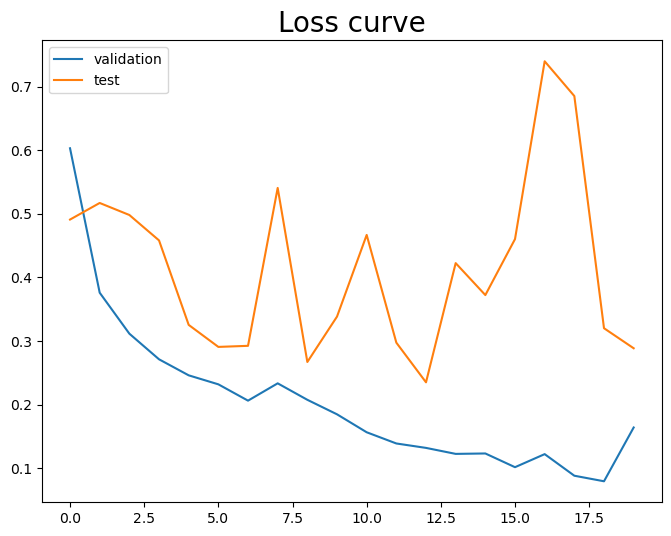

In [126]:
plt.figure(figsize=(8,6))
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['validation', 'test'], loc='upper left')
plt.title('Loss curve',fontdict={'size':20})
plt.show()

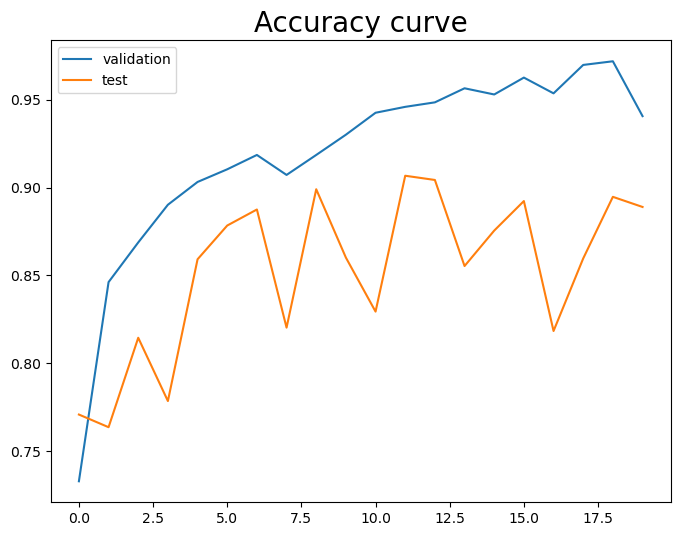

In [124]:
plt.figure(figsize=(8,6))
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.legend(['validation', 'test'], loc='upper left')
plt.title('Accuracy curve',fontdict={'size':20})
plt.show()

In [134]:
Y_pred_CNN = CNN.predict(X_test3)
Y_pred_CNN = np.round(Y_pred_CNN)

recall_CNN = recall_score(Y_test3, Y_pred_CNN)
precision_CNN = precision_score(Y_test3, Y_pred_CNN)
f1_CNN = f1_score(Y_test3, Y_pred_CNN)
roc_CNN = roc_auc_score(Y_test3, Y_pred_CNN)
print('Recall score for CNN: ', recall_CNN)
print('Precision score for CNN: ', precision_CNN)
print('F1 score for CNN: ', f1_CNN)
print('ROC score for CNN: ', roc_CNN)

66/66 [==============================] - 2s 33ms/step
Recall score for CNN:  0.8864059590316573
Precision score for CNN:  0.9242718446601942
F1 score for CNN:  0.9049429657794676
ROC score for CNN:  0.9044740817998406


In [132]:
CNN_Classification_Report = classification_report(Y_test3, Y_pred_CNN)
print(CNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1007
           1       0.92      0.89      0.90      1074

    accuracy                           0.90      2081
   macro avg       0.90      0.90      0.90      2081
weighted avg       0.90      0.90      0.90      2081



### Observation:
<li> For class 0, the precision is 0.88. This means that 88% of the instances predicted as class 0 are actually class 0. </li>
<li> For class 1, the precision is 0.92. This means that 92% of the instances predicted as class 1 are actually class 1. </li>
<li> For class 0, the recall is 0.92. This indicates that the model correctly identified 92% of the actual class 0 instances. </li>
<li> For class 1, the recall is 0.89. This indicates that the model correctly identified 89% of the actual class 1 instances. </li>
<li> For class 0, the F1-score is 0.90. For class 1, the F1-score is 0.90. </li>


### Conclusion:
<li> Of all the models, CNN performed with the highest accuracy of 94.07% in classifying the male eye and female eye.</li>
<li> Early Stopping has helped in preventing overfitting and improved the performance of the model. </li>